In [ ]:
"""
Pixel Coordinate Prediction using CNN

Name : Anuraag
Email: choppadandianuraag@gmail.com
Date: February 2026

Description:
This notebook implements a CNN model to predict pixel coordinates 
in 50x50 grayscale images with sub-pixel accuracy.

Performance: 0.26 pixel mean error (99.5% accuracy)

"""


## Dataset Rationale

### Why Synthetic Data?
The problem requires predicting the (x, y) coordinates of a single bright pixel (value=255)
in a 50x50 grayscale image where all other pixels are 0. Since no real-world dataset
exists for this specific task, synthetic data generation is the natural and correct choice.
It gives us full control over labels, scale, and distribution.

### Dataset Size & Split
- Total samples: 10,000 images
- Train: 8,000 | Validation: 1,000 | Test: 1,000
- This size is sufficient because each sample is simple and unique — one pixel lit,
  rest are zero. The model doesn't need millions of examples to generalize.

### Distribution Choice: Uniform Random
The bright pixel position is sampled uniformly across all 2,500 possible (x, y) locations
in the 50x50 grid. This ensures:
- No positional bias — the model learns to detect the pixel anywhere in the image
- Balanced representation of all coordinate values from (0,0) to (49,49)
- Fair evaluation since no region is over- or under-represented

### Label Format
Coordinates are stored as continuous float values normalized to [0, 1] range
(i.e., x/49 and y/49), making it a proper regression task compatible with the
Dense(2) output layer.
```


#### Attempt 1: Simple CNN (v1)
- Architecture: 3 conv blocks (16→32→64)
- Loss: MSE
- Result: val_mae = 0.1864 pixels
- Issue: Good but room for improvement

#### Attempt 2: Simple CNN (v2) (Used)
- Architecture: Same as v1 
- Loss: **Huber loss** (more robust to outliers)
- Optimizer: Adam with ReduceLROnPlateau
- Result: val_mae = 0.1731 pixels, test_mae = 0.26 pixels
- **Why it worked**: Huber loss + proper callbacks prevented overfitting

#### Attempt 3: Deeper CNN (v3)
- Architecture: 6 conv layers (32→64→128)
- Result: Worse performance (overfitting)
- **Learning**: More complexity ≠ better performance for this problem


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, ReLU, MaxPooling2D,
    Dropout, Flatten, Dense, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

In [3]:
# Loads training and validation image datasets from directories
DATA_DIR = 'images'  # Path to images folder in the same directory

# Training data
train_images = tf.data.Dataset.list_files(
    os.path.join(DATA_DIR, 'train', '*.png'), 
    shuffle=True
)

# Validation data
val_images = tf.data.Dataset.list_files(
    os.path.join(DATA_DIR, 'val', '*.png'), 
    shuffle=False
)

# Test data
test_images = tf.data.Dataset.list_files(
    os.path.join(DATA_DIR, 'test', '*.png'), 
    shuffle=False
)

In [4]:
# Preview first image path
train_images.as_numpy_iterator().next()


def load_image(file_path):
    """Load and decode a PNG image file.
    
    Args:

        file_path: Path to the image fileimages = train_images.map(load_image)

        # Map the load function to all training images

    Returns:

        Decoded grayscale image tensor

    """
    byte_img = tf.io.read_file(file_path) 
    img = tf.io.decode_png(byte_img, channels=1)  # Grayscale
    return img

images=train_images.map(load_image)   

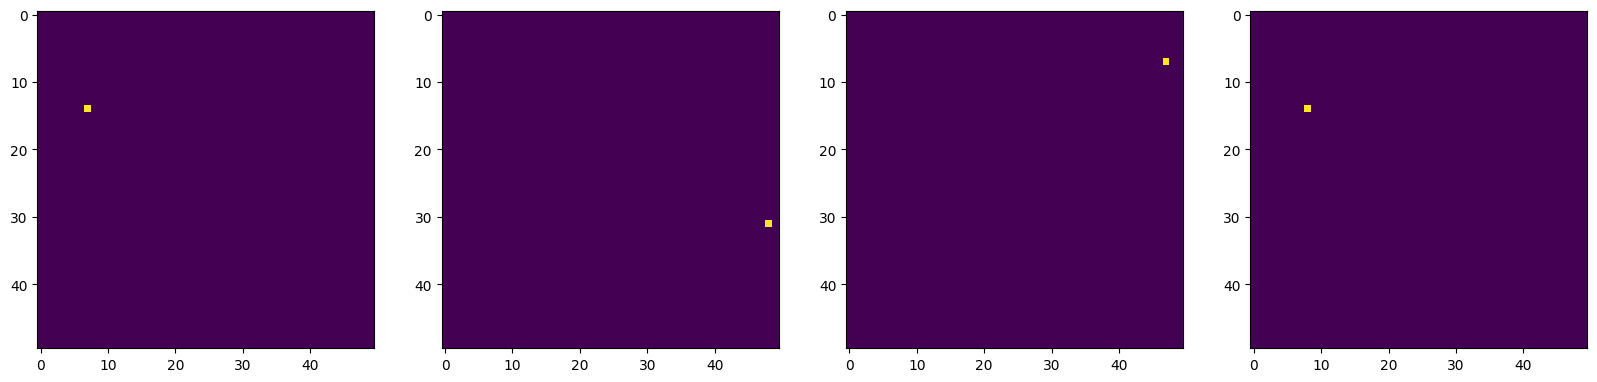

In [5]:
# Visualize sample images from the dataset
image_generator = images.batch(4).as_numpy_iterator()

# Calculate total number of images
dataset_length = len(list(images.as_numpy_iterator()))
print(f"Total images in dataset: {dataset_length}")

# Display 4 sample images
plot_img = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(plot_img):

    ax[idx].imshow(image)
plt.show()


In [6]:
# Preprocess training images: load, resize, and normalize
train_img = train_images.map(load_image)
train_img = train_img.map(lambda x: tf.image.resize(x, (50, 50)))
train_img = train_img.map(lambda x: x / 255.0)  # Normalize to [0, 1]

# Preprocess test images: load, resize, and normalize
test_img = test_images.map(load_image)
test_img = test_img.map(lambda x: tf.image.resize(x, (50, 50)))
test_img = test_img.map(lambda x: x / 255.0)

# Preprocess validation images: load, resize, and normalize
val_img = val_images.map(load_image)
val_img = val_img.map(lambda x: tf.image.resize(x, (50, 50)))
val_img = val_img.map(lambda x: x / 255.0)


In [9]:
# Load pixel coordinate labels from CSV

data = pd.read_csv('pixel_coordinates.csv')

In [10]:
# Split data into train, validation, and test sets
train_df = data[data['split'] == 'train']
val_df = data[data['split'] == 'val']
test_df = data[data['split'] == 'test']

In [12]:
# Extract coordinate labels as numpy arrays
y_train = train_df[['x', 'y']].values
y_val = val_df[['x', 'y']].values
y_test = test_df[['x', 'y']].values

In [13]:
train_labels = tf.data.Dataset.from_tensor_slices(y_train)
val_labels = tf.data.Dataset.from_tensor_slices(y_val)
test_labels = tf.data.Dataset.from_tensor_slices(y_test)

In [14]:
# Create training dataset pipeline
train = tf.data.Dataset.zip((train_img, train_labels))
train = train.shuffle(8000)  # Shuffle with buffer size 8000
train = train.batch(32)  # Batch size of 32
train = train.prefetch(4)  # Prefetch 4 batches for performance

# Create test dataset pipeline
test = tf.data.Dataset.zip((test_img, test_labels))
test = test.shuffle(1000)
test = test.batch(8)
test = test.prefetch(4)

# Create validation dataset pipeline
val = tf.data.Dataset.zip((val_img, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

### Model Architecture

In [18]:
def build_simple_cnn(input_shape=(50, 50, 1)):
    """
    Builds a simple Convolutional Neural Network (CNN) model
    for image classification.
    """
    model = Sequential([
        Conv2D(16, 3, padding='same', input_shape=input_shape),# First convolutional block
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(2, 2),  # Reduces size to 25x25
        Conv2D(32, 3, padding='same'),# Second convolutional block
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(2, 2), # Reduces size to 12x12
        Conv2D(64, 3, padding='same'),# Third convolutional block
        BatchNormalization(),
        ReLU(),
        # Fully connected layers
        Flatten(),
        Dense(64, activation='relu'),
        Dense(2)# Output layer for 2 classes
    ])
    return model

model=build_simple_cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 16)        160       
                                                                 
 batch_normalization (Batch  (None, 50, 50, 16)        64        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 50, 50, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 25, 25, 32)        1

In [ ]:
def build_augmented_cnn_v3(input_shape=(50, 50, 1)):
    model = Sequential([
        # Remove RandomRotation, RandomTranslation, RandomZoom from here

        Conv2D(32, 3, padding='same', input_shape=input_shape),
        BatchNormalization(),
        ReLU(),
        Conv2D(32, 3, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(2, 2),

        Conv2D(64, 3, padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(64, 3, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(2, 2),

        Conv2D(128, 3, padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(128, 3, padding='same'),
        BatchNormalization(),
        ReLU(),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(2)
    ])
    return model

# Build and compile


In [ ]:
# Compile model v1 with MSE loss
model.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error for regression
    metrics=['mae']  # Mean Absolute Error
)

In [ ]:
# Build and compile model v2 with Huber loss (best performing)
model_v2 = build_simple_cnn()

model_v2.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with lr=0.001
    loss='huber',  # Huber loss: robust to outliers
    metrics=['mae', 'mse']  # Track MAE and MSE during training
)

In [ ]:
# Build and compile model v3 (deeper architecture)
model_v3 = build_augmented_cnn_v3()
model_v3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='huber',  # Huber loss: robust to outliers
    metrics=['mae', 'mse']  # Track MAE and MSE during training)

In [ ]:
# Early stopping - stops training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Wait 10 epochs before stopping
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce LR by half
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Save best model
model_checkpoint = ModelCheckpoint(
    '../models/best_pixel_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
# Early stopping - stops training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Wait 10 epochs before stopping
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce LR by half
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Save best model
model_checkpoint_v2 = ModelCheckpoint(
    'models/best_pixel_model_v2.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks_v2 = [early_stopping, reduce_lr, model_checkpoint_v2]

### Model Training

In [ ]:
# Train model v1 (MSE loss)
history = model.fit(
    train,
    validation_data=val,
    epochs=50,
    callbacks=callbacks  # Early stopping, LR reduction, checkpointing
)

Epoch 1/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 82.0315 - mae: 4.8584
Epoch 1: val_loss improved from inf to 218.62126, saving model to models/best_pixel_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 185s 637ms/step - loss: 81.5465 - mae: 4.8360 - val_loss: 218.6213 - val_mae: 12.5338 - learning_rate: 0.0010
Epoch 2/50
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8658 - mae: 0.7041
Epoch 2: val_loss improved from 218.62126 to 99.83685, saving model to models/best_pixel_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 0.8635 - mae: 0.7031 - val_loss: 99.8369 - val_mae: 8.3618 - learning_rate: 0.0010
Epoch 3/50
241/250 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3857 - mae: 0.4831
Epoch 3: val_loss improved from 99.83685 to 7.67149, saving model to models/best_pixel_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 0.3847 - mae: 0.4823 - val_loss: 7.6715 - val_mae: 2.1690 - learning_rate: 0.0010
Epoch 4/50
245/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3272 - mae: 0.4398
Epoch 4: val_loss improved from 7.67149 to 6.13537, saving model to models/best_pixel_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.3266 - mae: 0.4394 - val_loss: 6.1354 - val_mae: 2.0976 - learning_rate: 0.0010
Epoch 5/50
240/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3326 - mae: 0.4477
Epoch 5: val_loss did not improve from 6.13537
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 0.3325 - mae: 0.4476 - val_loss: 9.6445 - val_mae: 2.7576 - learning_rate: 0.0010
Epoch 6/50
240/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2710 - mae: 0.4063
Epoch 6: val_loss improved from 6.13537 to 1.90311, saving model to models/best_pixel_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 0.2702 - mae: 0.4057 - val_loss: 1.9031 - val_mae: 1.2244 - learning_rate: 0.0010
Epoch 7/50
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2609 - mae: 0.4010
Epoch 7: val_loss improved from 1.90311 to 0.30957, saving model to models/best_pixel_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.2610 - mae: 0.4010 - val_loss: 0.3096 - val_mae: 0.3893 - learning_rate: 0.0010
Epoch 8/50
242/250 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2519 - mae: 0.3876
Epoch 8: val_loss did not improve from 0.30957
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 0.2529 - mae: 0.3882 - val_loss: 31.5690 - val_mae: 5.0231 - learning_rate: 0.0010
Epoch 9/50
244/250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2971 - mae: 0.4229
Epoch 9: val_loss improved from 0.30957 to 0.24312, saving model to models/best_pixel_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 0.2978 - mae: 0.4234 - val_loss: 0.2431 - val_mae: 0.3190 - learning_rate: 0.0010
Epoch 10/50
241/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2622 - mae: 0.3913
Epoch 10: val_loss did not improve from 0.24312
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.2614 - mae: 0.3907 - val_loss: 1.4680 - val_mae: 1.0649 - learning_rate: 0.0010
Epoch 11/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1971 - mae: 0.3421
Epoch 11: val_loss did not improve from 0.24312
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.1973 - mae: 0.3423 - val_loss: 30.6341 - val_mae: 5.0021 - learning_rate: 0.0010
Epoch 12/50
245/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2042 - mae: 0.3486
Epoch 12: val_loss did not improve from 0.24312
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.2040 - mae: 0.3484 - val_loss: 15.6480 - val_mae: 3.5287 - learning_rate: 0.0010
Epoch 13/50
241/250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2217 - mae: 0

250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 0.0466 - mae: 0.1653 - val_loss: 0.1121 - val_mae: 0.1864 - learning_rate: 5.0000e-04
Epoch 18/50
240/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0417 - mae: 0.1566
Epoch 18: val_loss did not improve from 0.11208
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0419 - mae: 0.1571 - val_loss: 2.7074 - val_mae: 1.4394 - learning_rate: 5.0000e-04
Epoch 19/50
244/250 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0474 - mae: 0.1669
Epoch 19: val_loss did not improve from 0.11208
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 0.0474 - mae: 0.1670 - val_loss: 0.5588 - val_mae: 0.6845 - learning_rate: 5.0000e-04
Epoch 20/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0507 - mae: 0.1707
Epoch 20: val_loss did not improve from 0.11208
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.0507 - mae: 0.1707 - val_loss: 7.2334 - val_mae: 2.4949 - learning_rate: 5.0000e-04
Epoch 21/50
245/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0

In [ ]:
# Train model v2 with Huber loss (best performing model)
history_v2 = model_v2.fit(
    train,
    validation_data=val,
    epochs=30,
    callbacks=callbacks_v2  # Early stopping, LR reduction, checkpointing
)

Epoch 1/30
246/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3252 - mae: 3.7607 - mse: 55.9338
Epoch 1: val_loss improved from inf to 12.29237, saving model to models/best_pixel_model_v2.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 3.2873 - mae: 3.7224 - mse: 55.1088 - val_loss: 12.2924 - val_mae: 12.7837 - val_mse: 235.7966 - learning_rate: 0.0010
Epoch 2/30
243/250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4344 - mae: 0.8042 - mse: 1.0820
Epoch 2: val_loss improved from 12.29237 to 9.27920, saving model to models/best_pixel_model_v2.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - loss: 0.4333 - mae: 0.8029 - mse: 1.0789 - val_loss: 9.2792 - val_mae: 9.7658 - val_mse: 147.0597 - learning_rate: 0.0010
Epoch 3/30
240/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3777 - mae: 0.7320 - mse: 0.9104
Epoch 3: val_loss improved from 9.27920 to 2.91879, saving model to models/best_pixel_model_v2.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.3759 - mae: 0.7298 - mse: 0.9053 - val_loss: 2.9188 - val_mae: 3.3854 - val_mse: 15.8779 - learning_rate: 0.0010
Epoch 4/30
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2329 - mae: 0.5454 - mse: 0.5283
Epoch 4: val_loss did not improve from 2.91879
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 0.2326 - mae: 0.5450 - mse: 0.5275 - val_loss: 2.9643 - val_mae: 3.4623 - val_mse: 14.0383 - learning_rate: 0.0010
Epoch 5/30
244/250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2273 - mae: 0.5383 - mse: 0.5092
Epoch 5: val_loss did not improve from 2.91879
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 0.2272 - mae: 0.5381 - mse: 0.5089 - val_loss: 5.5705 - val_mae: 6.0699 - val_mse: 43.3112 - learning_rate: 0.0010
Epoch 6/30
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1710 - mae: 0.4586 - mse: 0.3658
Epoch 6: val_loss did not improve from 2.91879
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.1711 - mae: 0.4587 - ms

250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 0.1650 - mae: 0.4461 - mse: 0.3544 - val_loss: 0.9545 - val_mae: 1.4112 - val_mse: 2.5774 - learning_rate: 0.0010
Epoch 8/30
242/250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1495 - mae: 0.4226 - mse: 0.3168
Epoch 8: val_loss improved from 0.95453 to 0.40061, saving model to models/best_pixel_model_v2.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 0.1493 - mae: 0.4225 - mse: 0.3165 - val_loss: 0.4006 - val_mae: 0.7628 - val_mse: 0.9929 - learning_rate: 0.0010
Epoch 9/30
242/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1318 - mae: 0.3947 - mse: 0.2746
Epoch 9: val_loss did not improve from 0.40061
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.1311 - mae: 0.3934 - mse: 0.2730 - val_loss: 1.4259 - val_mae: 1.9123 - val_mse: 4.3260 - learning_rate: 0.0010
Epoch 10/30
242/250 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0852 - mae: 0.3158 - mse: 0.1746
Epoch 10: val_loss improved from 0.40061 to 0.37608, saving model to models/best_pixel_model_v2.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0856 - mae: 0.3165 - mse: 0.1755 - val_loss: 0.3761 - val_mae: 0.7321 - val_mse: 0.8918 - learning_rate: 0.0010
Epoch 11/30
243/250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0889 - mae: 0.3203 - mse: 0.1811
Epoch 11: val_loss did not improve from 0.37608
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0887 - mae: 0.3199 - mse: 0.1806 - val_loss: 9.8725 - val_mae: 10.3719 - val_mse: 128.4108 - learning_rate: 0.0010
Epoch 12/30
242/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1056 - mae: 0.3515 - mse: 0.2172
Epoch 12: val_loss did not improve from 0.37608
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.1051 - mae: 0.3506 - mse: 0.2162 - val_loss: 0.6312 - val_mae: 1.0417 - val_mse: 1.6122 - learning_rate: 0.0010
Epoch 13/30
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1042 - mae: 0.3455 - mse: 0.2157
Epoch 13: val_loss did not improve from 0.37608
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 0.1041 - mae: 0.345

250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 0.0715 - mae: 0.2749 - mse: 0.1468 - val_loss: 0.2487 - val_mae: 0.6332 - val_mse: 0.5258 - learning_rate: 5.0000e-04
Epoch 17/30
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219 - mae: 0.1570 - mse: 0.0439
Epoch 17: val_loss did not improve from 0.24874
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.0219 - mae: 0.1571 - mse: 0.0439 - val_loss: 1.3059 - val_mae: 1.7841 - val_mse: 3.7962 - learning_rate: 5.0000e-04
Epoch 18/30
244/250 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0209 - mae: 0.1512 - mse: 0.0421
Epoch 18: val_loss did not improve from 0.24874
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0209 - mae: 0.1511 - mse: 0.0420 - val_loss: 0.3379 - val_mae: 0.7786 - val_mse: 0.6889 - learning_rate: 5.0000e-04
Epoch 19/30
243/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0184 - mae: 0.1429 - mse: 0.0368
Epoch 19: val_loss did not improve from 0.24874
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0184 - m

250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 0.0218 - mae: 0.1581 - mse: 0.0436 - val_loss: 0.0310 - val_mae: 0.1731 - val_mse: 0.0824 - learning_rate: 5.0000e-04
Epoch 21/30
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0195 - mae: 0.1457 - mse: 0.0391
Epoch 21: val_loss did not improve from 0.03101
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 0.0196 - mae: 0.1460 - mse: 0.0393 - val_loss: 4.3498 - val_mae: 4.8482 - val_mse: 28.0402 - learning_rate: 5.0000e-04
Epoch 22/30
247/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0222 - mae: 0.1578 - mse: 0.0445
Epoch 22: val_loss did not improve from 0.03101
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.0222 - mae: 0.1579 - mse: 0.0445 - val_loss: 0.1214 - val_mae: 0.4573 - val_mse: 0.2506 - learning_rate: 5.0000e-04
Epoch 23/30
242/250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0284 - mae: 0.1782 - mse: 0.0568
Epoch 23: val_loss did not improve from 0.03101
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 0.0283 - 

In [19]:
# Rebuild the model architecture and load weights only
# This avoids Keras version compatibility issues
model_v2 = build_simple_cnn()

# Load only the weights from the saved model
model_v2.load_weights('models/best_pixel_model_v2.h5')

# Recompile the model
model_v2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='huber',
    metrics=['mae', 'mse']
)

## Testing

In [22]:
# Convert TensorFlow Dataset to numpy arrays for evaluation
test_images_list = []
test_labels_list = []

# Iterate through test batches and collect data
for images, labels in test:
    test_images_list.append(images.numpy())
    test_labels_list.append(labels.numpy())

# Concatenate all batches into single arrays
test_images_array = np.concatenate(test_images_list, axis=0)
test_labels_array = np.concatenate(test_labels_list, axis=0)

print(f"test_images shape: {test_images_array.shape}")
print(f"test_labels shape: {test_labels_array.shape}")

# Now predict
y_pred = model_v2.predict(test_images_array)

# Evaluate
test_loss, test_mae, test_mse = model_v2.evaluate(test_images_array, test_labels_array, verbose=0)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f} pixels")
print(f"Test MSE: {test_mse:.4f}")

# Display sample predictions
print("\nSample Predictions vs Actual:")
print("-" * 50)
for i in range(min(10, len(y_pred))):
    pred_x, pred_y = y_pred[i]
    actual_x, actual_y = test_labels_array[i]
    error = np.sqrt((pred_x - actual_x)**2 + (pred_y - actual_y)**2)
    print(f"Sample {i+1}: Pred ({pred_x:.2f}, {pred_y:.2f}) | Actual ({actual_x:.2f}, {actual_y:.2f}) | Error: {error:.2f}px")

# Overall statistics
errors = np.sqrt(np.sum((y_pred - test_labels_array)**2, axis=1))
print(f"\nOverall Error Statistics:")
print(f"Mean Error: {np.mean(errors):.4f} pixels")
print(f"Median Error: {np.median(errors):.4f} pixels")

test_images shape: (1000, 50, 50, 1)
test_labels shape: (1000, 2)
32/32 [==============================] - 0s 3ms/step

Test Loss: 0.0240
Test MAE: 0.1653 pixels
Test MSE: 0.0546

Sample Predictions vs Actual:
--------------------------------------------------
Sample 1: Pred (9.86, 16.71) | Actual (10.00, 17.00) | Error: 0.33px
Sample 2: Pred (28.00, 45.67) | Actual (28.00, 46.00) | Error: 0.33px
Sample 3: Pred (35.14, 19.98) | Actual (35.00, 20.00) | Error: 0.14px
Sample 4: Pred (2.12, 31.83) | Actual (2.00, 32.00) | Error: 0.21px
Sample 5: Pred (27.09, 38.74) | Actual (27.00, 39.00) | Error: 0.27px
Sample 6: Pred (19.02, 13.92) | Actual (19.00, 14.00) | Error: 0.09px
Sample 7: Pred (28.71, 19.81) | Actual (29.00, 20.00) | Error: 0.35px
Sample 8: Pred (27.14, 0.12) | Actual (27.00, 0.00) | Error: 0.18px
Sample 9: Pred (15.94, 13.00) | Actual (16.00, 13.00) | Error: 0.06px
Sample 10: Pred (28.04, 42.61) | Actual (28.00, 43.00) | Error: 0.40px

Overall Error Statistics:
Mean Error: 0.26

## Visualizations

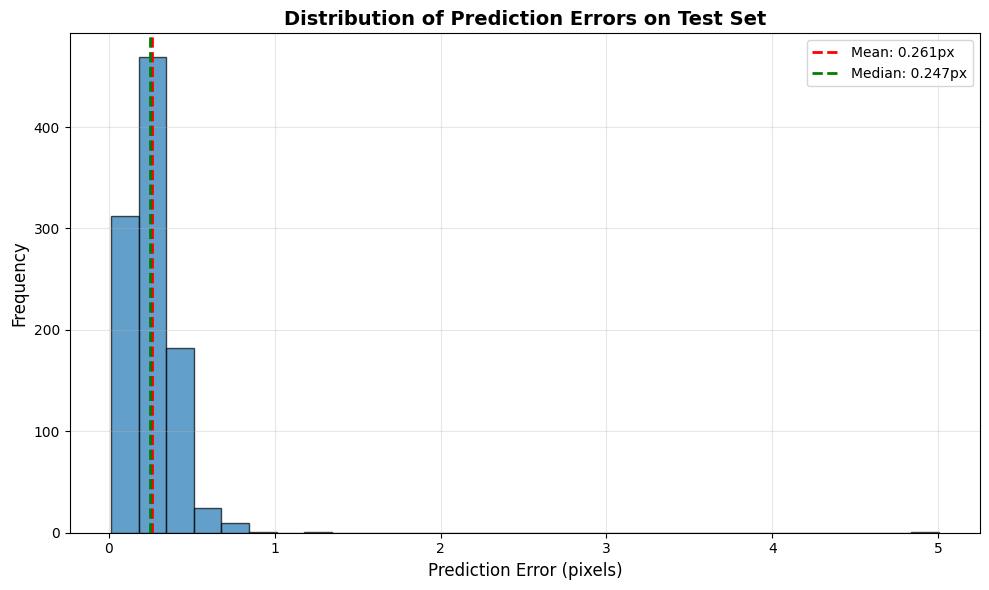

In [23]:
# 1. Error Distribution Histogram
plt.figure(figsize=(10, 6))
errors = np.sqrt(np.sum((y_pred - test_labels_array)**2, axis=1))
plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(errors), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(errors):.3f}px')
plt.axvline(np.median(errors), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(errors):.3f}px')
plt.xlabel('Prediction Error (pixels)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Prediction Errors on Test Set', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


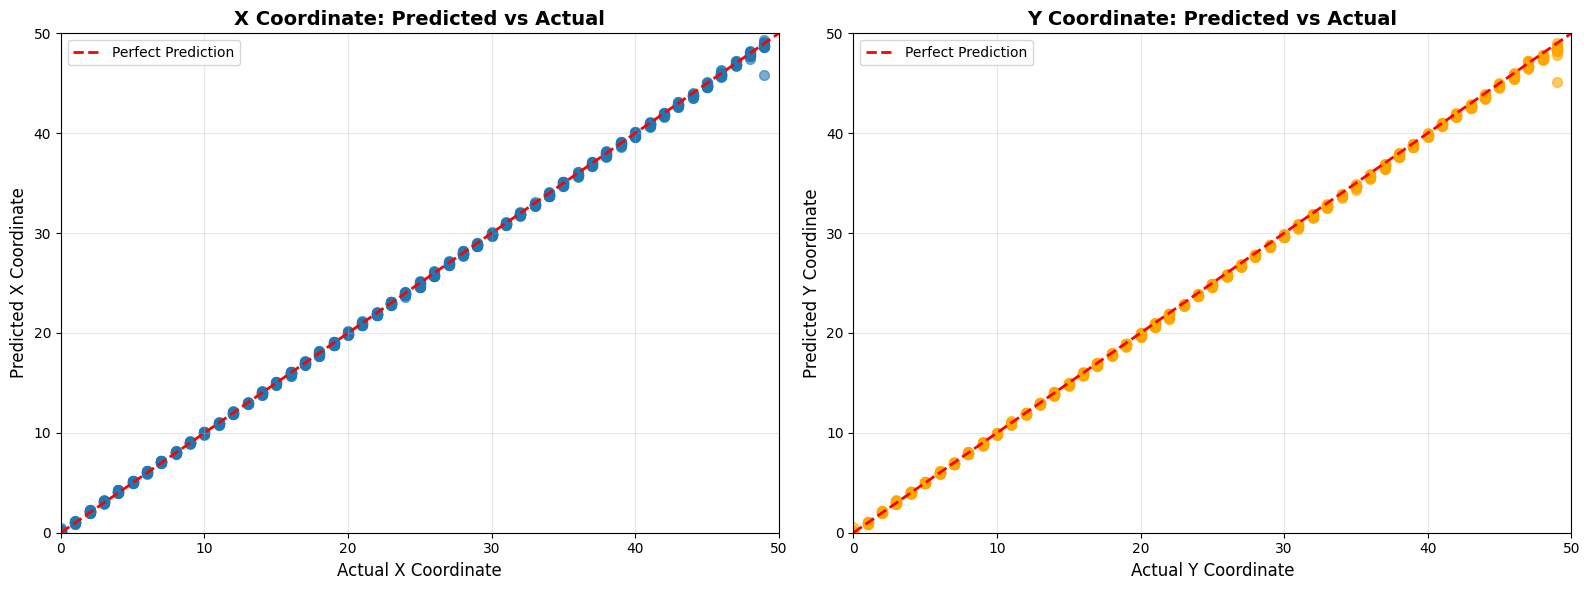

In [24]:
# 2. Scatter Plot: Predicted vs Actual (X and Y coordinates)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# X coordinates
axes[0].scatter(test_labels_array[:, 0], y_pred[:, 0], alpha=0.6, s=50)
axes[0].plot([0, 50], [0, 50], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual X Coordinate', fontsize=12)
axes[0].set_ylabel('Predicted X Coordinate', fontsize=12)
axes[0].set_title('X Coordinate: Predicted vs Actual', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 50])
axes[0].set_ylim([0, 50])

# Y coordinates
axes[1].scatter(test_labels_array[:, 1], y_pred[:, 1], alpha=0.6, s=50, color='orange')
axes[1].plot([0, 50], [0, 50], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Y Coordinate', fontsize=12)
axes[1].set_ylabel('Predicted Y Coordinate', fontsize=12)
axes[1].set_title('Y Coordinate: Predicted vs Actual', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 50])
axes[1].set_ylim([0, 50])

plt.tight_layout()
plt.show()

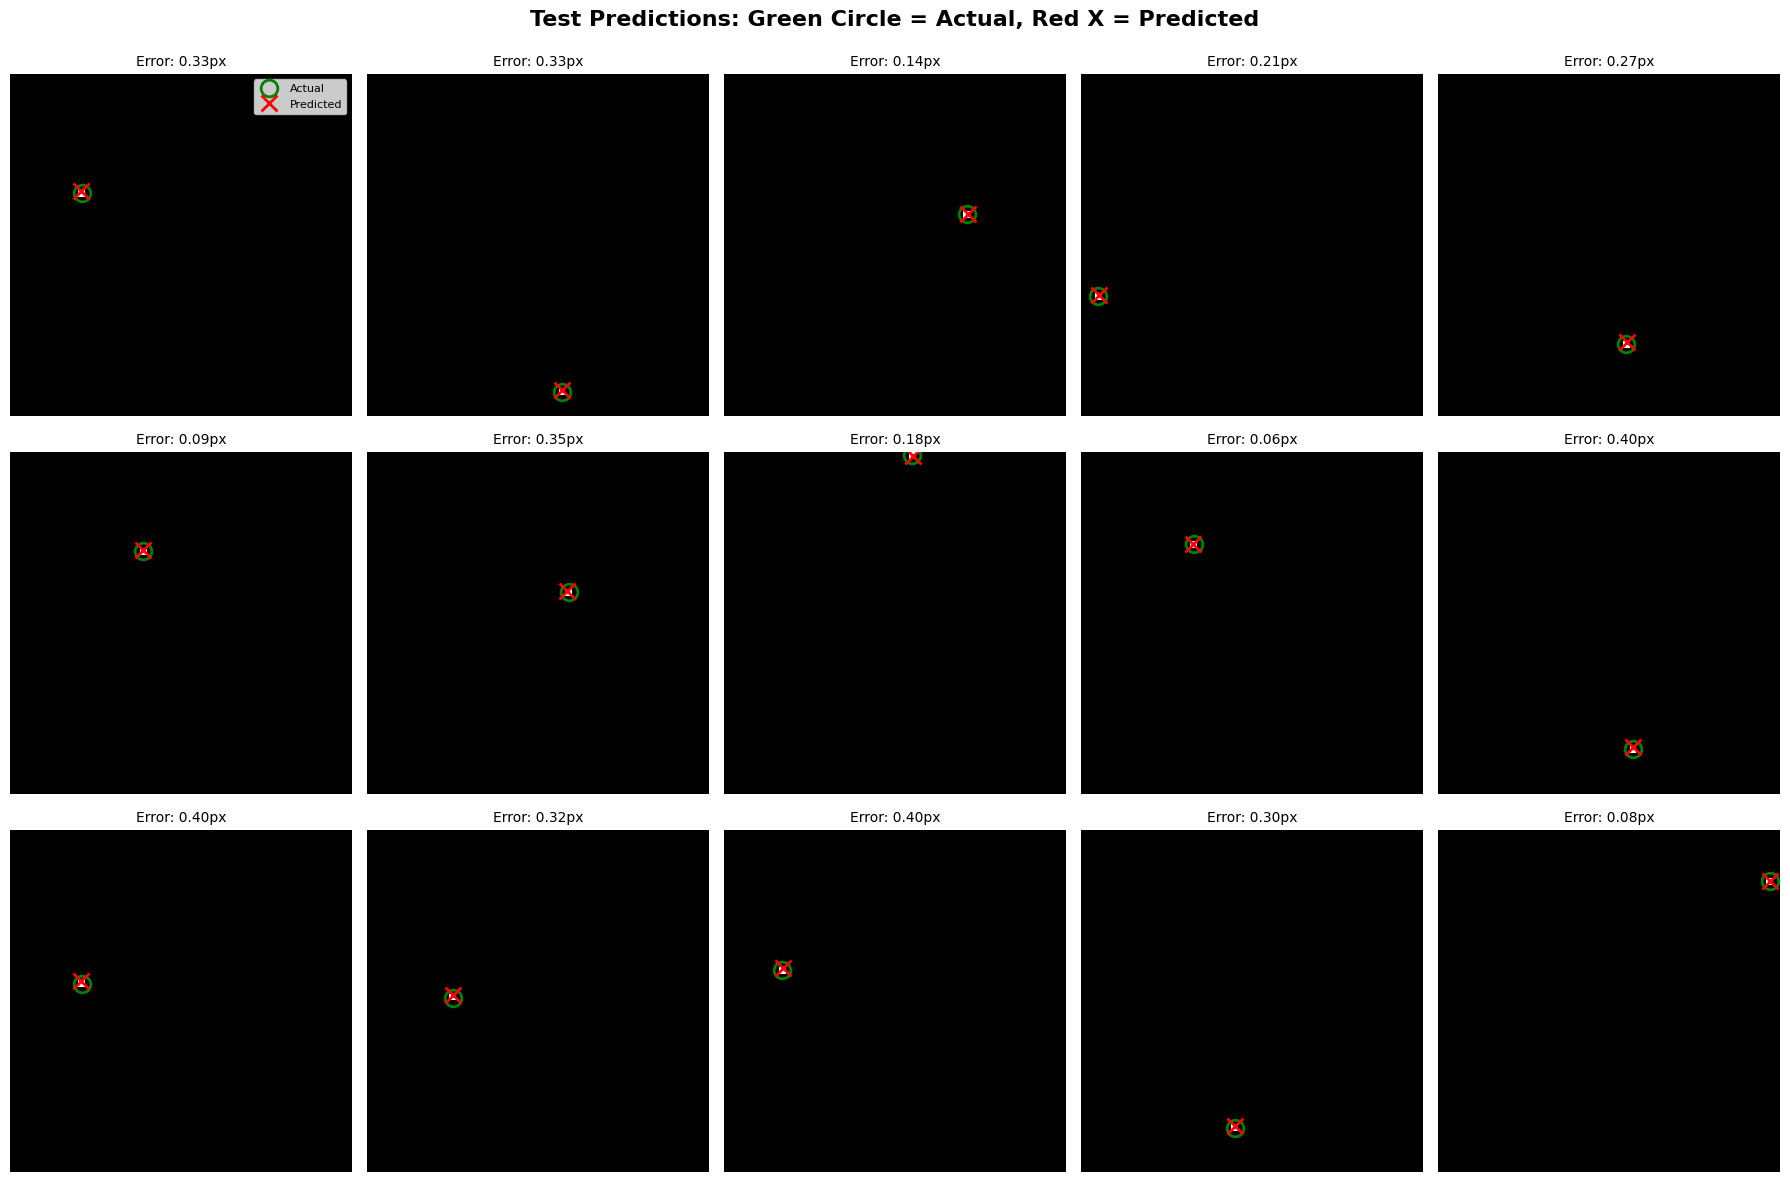

In [25]:
# 3. Visual comparison on actual images (showing predictions on images)
fig, axes = plt.subplots(3, 5, figsize=(18, 12))
axes = axes.flatten()

for i in range(min(15, len(test_images_array))):
    img = test_images_array[i].squeeze()  # Remove channel dimension for grayscale

    actual_x, actual_y = test_labels_array[i]
    pred_x, pred_y = y_pred[i]
    error = np.sqrt((pred_x - actual_x)**2 + (pred_y - actual_y)**2)

    axes[i].imshow(img, cmap='gray')

    # Plot actual position (green circle)
    axes[i].plot(actual_x, actual_y, 'go', markersize=12, label='Actual',
                 markerfacecolor='none', markeredgewidth=2)

    # Plot predicted position (red X)
    axes[i].plot(pred_x, pred_y, 'rx', markersize=12, label='Predicted',
                 markeredgewidth=2)

    axes[i].set_title(f'Error: {error:.2f}px', fontsize=10)
    axes[i].axis('off')

    if i == 0:
        axes[i].legend(loc='upper right', fontsize=8)

plt.suptitle('Test Predictions: Green Circle = Actual, Red X = Predicted',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


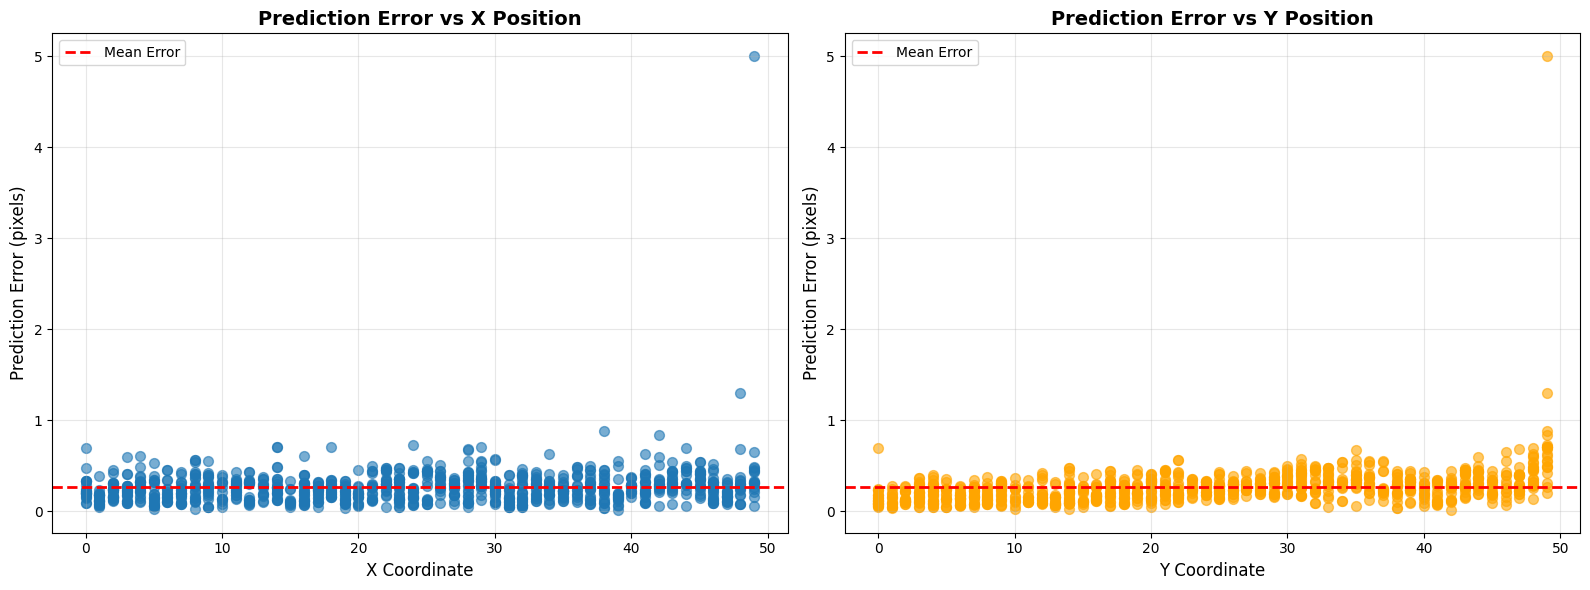

In [26]:
# 4. Error vs Position Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Error vs X position
axes[0].scatter(test_labels_array[:, 0], errors, alpha=0.6, s=50)
axes[0].axhline(np.mean(errors), color='red', linestyle='--', linewidth=2, label='Mean Error')
axes[0].set_xlabel('X Coordinate', fontsize=12)
axes[0].set_ylabel('Prediction Error (pixels)', fontsize=12)
axes[0].set_title('Prediction Error vs X Position', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error vs Y position
axes[1].scatter(test_labels_array[:, 1], errors, alpha=0.6, s=50, color='orange')
axes[1].axhline(np.mean(errors), color='red', linestyle='--', linewidth=2, label='Mean Error')
axes[1].set_xlabel('Y Coordinate', fontsize=12)
axes[1].set_ylabel('Prediction Error (pixels)', fontsize=12)
axes[1].set_title('Prediction Error vs Y Position', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# 5. Summary Statistics
print("\n" + "="*60)
print("FINAL TEST SET PERFORMANCE SUMMARY")
print("="*60)
print(f"Total Test Samples: {len(test_labels_array)}")
print(f"\nError Statistics:")
print(f"  Mean Error:   {np.mean(errors):.4f} pixels")
print(f"  Median Error: {np.median(errors):.4f} pixels")
print(f"  Std Dev:      {np.std(errors):.4f} pixels")
print(f"  Min Error:    {np.min(errors):.4f} pixels")
print(f"  Max Error:    {np.max(errors):.4f} pixels")
print(f"\nPercentiles:")
print(f"  25th: {np.percentile(errors, 25):.4f} pixels")
print(f"  50th: {np.percentile(errors, 50):.4f} pixels")
print(f"  75th: {np.percentile(errors, 75):.4f} pixels")
print(f"  95th: {np.percentile(errors, 95):.4f} pixels")
print(f"  99th: {np.percentile(errors, 99):.4f} pixels")
print("="*60)


FINAL TEST SET PERFORMANCE SUMMARY
Total Test Samples: 1000

Error Statistics:
  Mean Error:   0.2611 pixels
  Median Error: 0.2469 pixels
  Std Dev:      0.2025 pixels
  Min Error:    0.0125 pixels
  Max Error:    5.0026 pixels

Percentiles:
  25th: 0.1542 pixels
  50th: 0.2469 pixels
  75th: 0.3315 pixels
  95th: 0.4789 pixels
  99th: 0.6909 pixels
